In [27]:
import tensorflow as tf
import IPython.display as display
import PIL
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

import os
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16



In [28]:
data_dir = '/kaggle/input/mpdata/folder - Copy'
ds_name = 'Tomato dataset'
def generate_data_paths(data_dir):

    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)

        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)

    return df

df = create_df(filepaths, labels)

In [29]:
total_images = len(df)
print("Total number of images in the DataFrame:", total_images)

Total number of images in the DataFrame: 19109


In [30]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.keras import balanced_batch_generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd


# Splitting the data into train, validation, and test sets
train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=1253)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=1253)

# Define constants
batch_size = 40
img_size = (256, 256)
channels = 3

# Define image shape
img_shape = (img_size[0], img_size[1], channels)

# Calculate test batch size
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# Define image preprocessing function
def scalar(img):
    return img

# Define image data generators
tr_gen = ImageDataGenerator(preprocessing_function=scalar,
                            rescale=1.0 / 255,
#                             rotation_range=40,
#                             width_shift_range=0.2,
#                             height_shift_range=0.2,
#                             zoom_range=0.3,
                            horizontal_flip=True,
                            vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function=scalar,
                            rescale=1.0 / 255,
                            horizontal_flip=True,
                            vertical_flip=True)

# Oversample and undersample the training data
oversample = RandomOverSampler(sampling_strategy='auto', random_state=1253)
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=1253)

X_train, y_train = oversample.fit_resample(train_df[['filepaths']], train_df['labels'])
X_train, y_train = undersample.fit_resample(X_train, y_train)

train_resampled_df = pd.DataFrame({'filepaths': X_train.squeeze(), 'labels': y_train})

# Define image data generators for resampled training data
train_resampled_gen = tr_gen.flow_from_dataframe(train_resampled_df,
                                                 x_col='filepaths',
                                                 y_col='labels',
                                                 target_size=img_size,
                                                 class_mode='categorical',
                                                 color_mode='rgb',
                                                 shuffle=True,
                                                 batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col='filepaths',
                                       y_col='labels',
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=True,
                                       batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col='filepaths',
                                      y_col='labels',
                                      target_size=img_size,
                                      class_mode='categorical',
                                      color_mode='rgb',
                                      shuffle=False,
                                      batch_size=test_batch_size)

# Now you can use train_resampled_gen in place of train_gen in your training loop


Found 22510 validated image filenames belonging to 5 classes.
Found 2866 validated image filenames belonging to 5 classes.
Found 2867 validated image filenames belonging to 5 classes.


In [31]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

In [32]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)

In [33]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_layer_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [34]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [35]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [36]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(),
                    metrics=['accuracy'])


In [37]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
#rlr = ReduceLROnPlateau(patience=10, verbose=1)
es = EarlyStopping(patience=24, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint('model_tomato.keras', save_best_only=True, verbose=1)

In [38]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)

In [39]:
epochs = 30
history = model.fit(
  train_resampled_gen,
  callbacks=[rlr, es, mc],
  #callbacks=[rlr,mc],
  validation_data=valid_gen,
  epochs=epochs
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

W0000 00:00:1713360467.684364      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


380/563 ━━━━━━━━━━━━━━━━━━━━ 45s 249ms/step - accuracy: 0.7984 - loss: 0.5304

W0000 00:00:1713360562.206792      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.8335 - loss: 0.4411

W0000 00:00:1713360610.829783      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713360627.147452      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.19061, saving model to model_tomato.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 165s 285ms/step - accuracy: 0.8337 - loss: 0.4407 - val_accuracy: 0.9264 - val_loss: 0.1906 - learning_rate: 1.0000e-04
Epoch 2/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9770 - loss: 0.0640
Epoch 2: val_loss improved from 0.19061 to 0.04629, saving model to model_tomato.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 164s 290ms/step - accuracy: 0.9770 - loss: 0.0640 - val_accuracy: 0.9853 - val_loss: 0.0463 - learning_rate: 1.0000e-04
Epoch 3/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9891 - loss: 0.0311
Epoch 3: val_loss improved from 0.04629 to 0.03754, saving model to model_tomato.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 164s 289ms/step - accuracy: 0.9891 - loss: 0.0311 - val_accuracy: 0.9867 - val_loss: 0.0375 - learning_rate: 1.0000e-04
Epoch 4/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9881 - loss: 0.0330
Epoch 4: val_loss did not impro

In [40]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# learning_rate = history.history['lr']

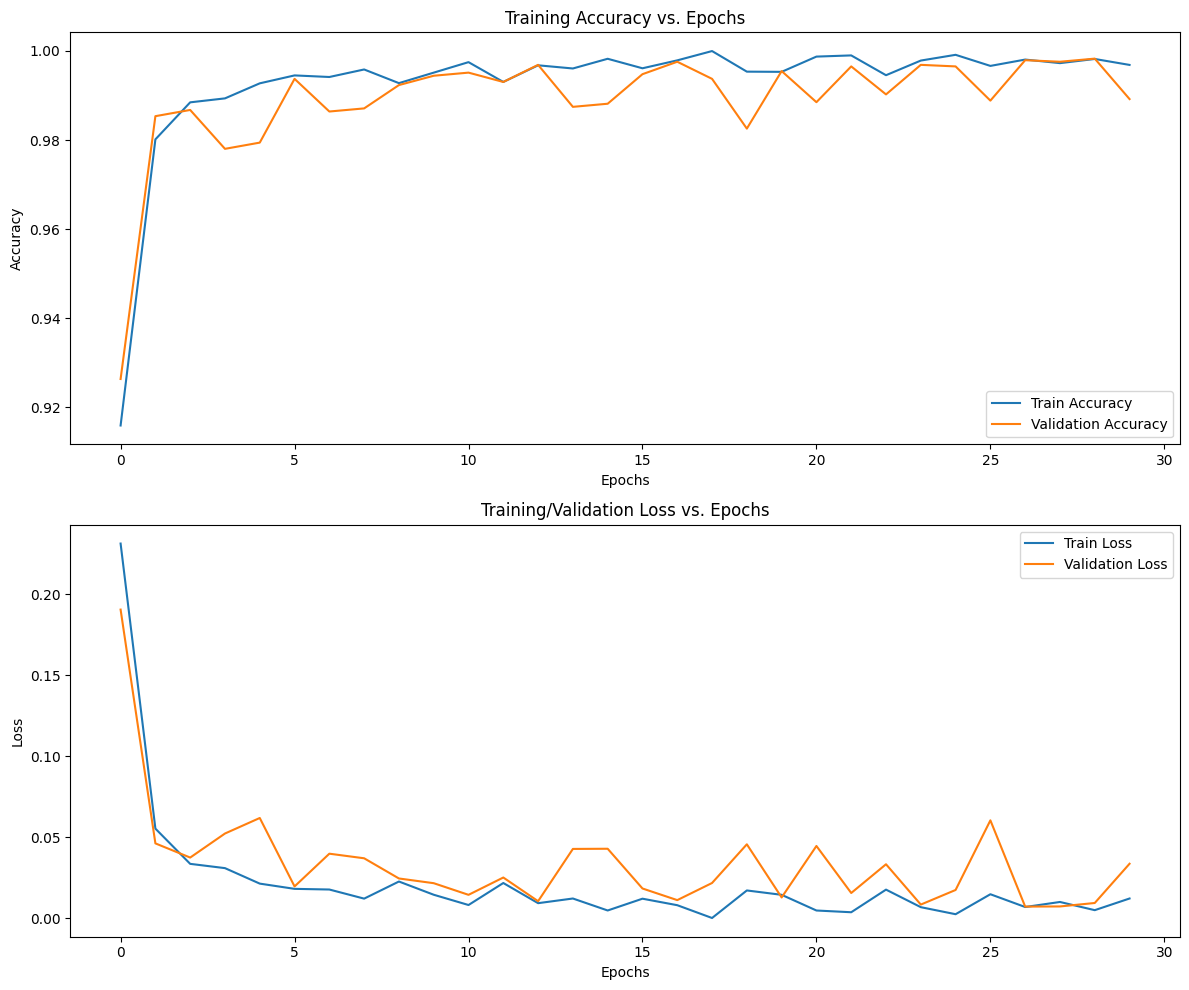

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, label='Train Accuracy')
ax[0].plot(val_accuracy, label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, label='Train Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

# ax[2].set_title('Learning Rate vs. Epochs')
# ax[2].plot(learning_rate, 'o-', label='Learning Rate')
# ax[2].set_xlabel('Epochs')
# ax[2].set_ylabel('Loss')
# ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [42]:
predictions = model.predict(test_gen)

 1/47 ━━━━━━━━━━━━━━━━━━━━ 42s 931ms/step

W0000 00:00:1713365395.338618      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 327ms/step


In [43]:
predictions.shape

(2867, 5)

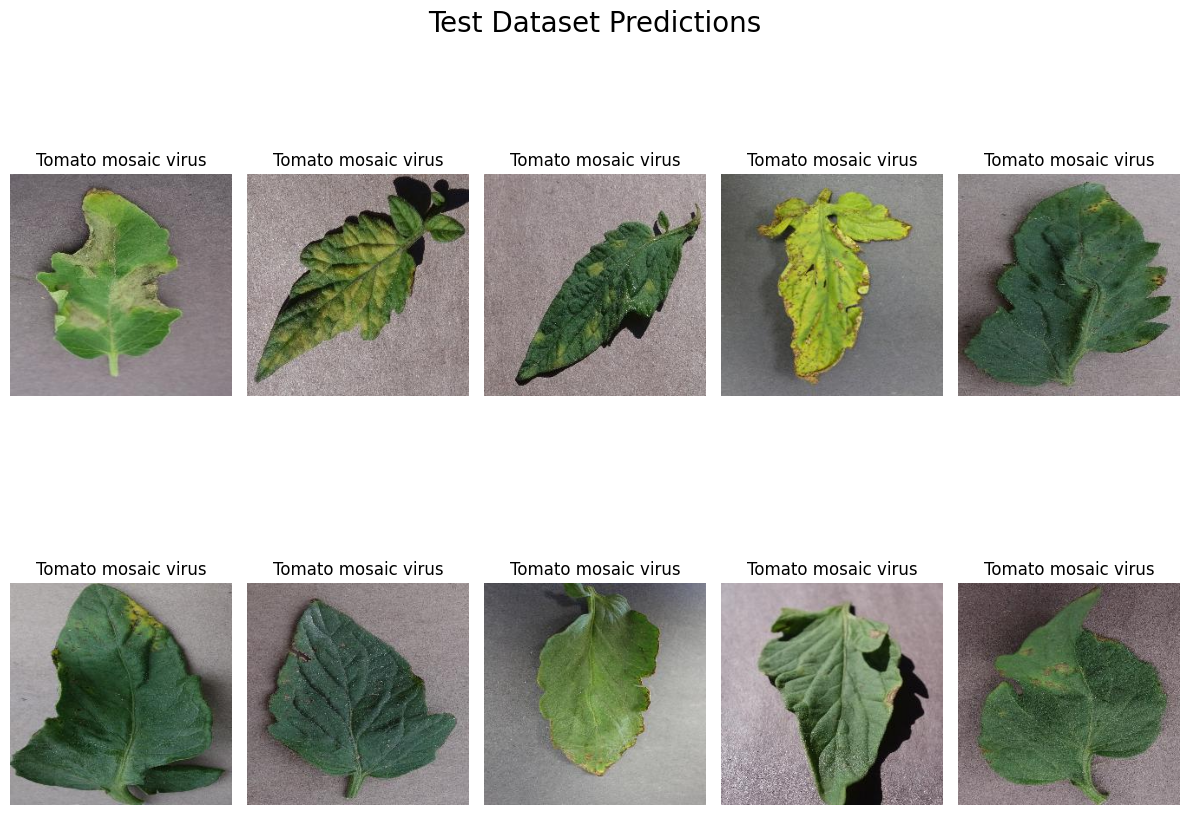

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_gen[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [45]:
test_loss, test_accuracy = model.evaluate(test_gen)

W0000 00:00:1713365414.812644      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 326ms/step - accuracy: 0.9982 - loss: 0.0108


In [46]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.009829995222389698
Test Accuracy: 0.9975584149360657


In [47]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes


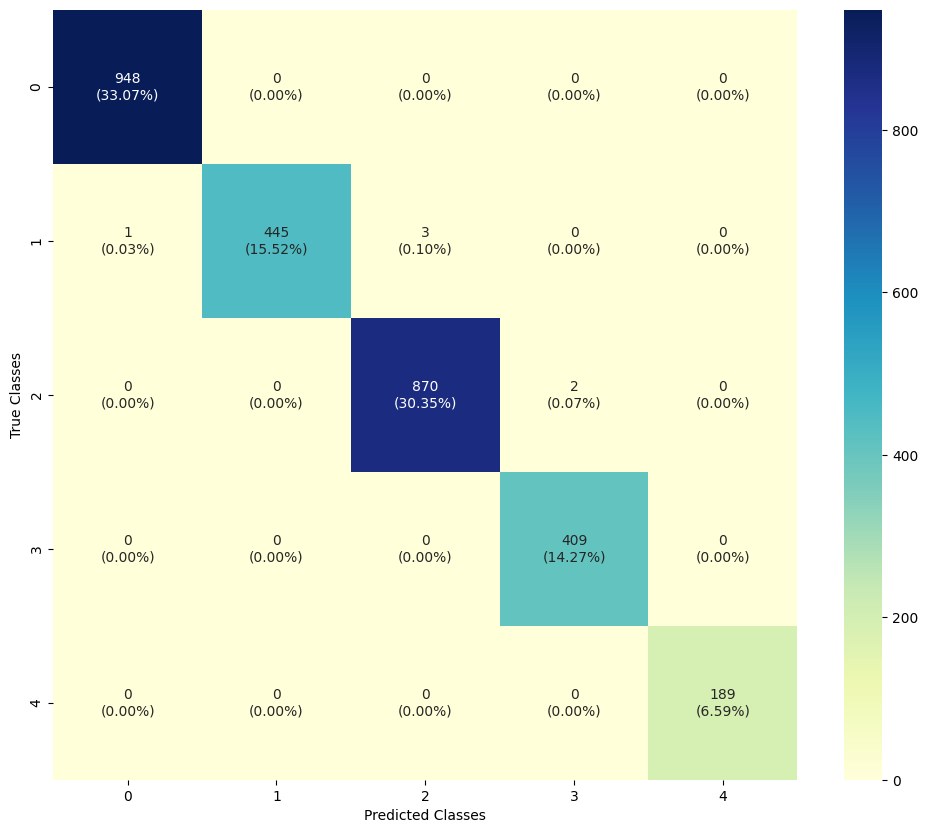

In [48]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(5, 5)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, #xticklabels=labels.values(), yticklabels=labels.values(),
            cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [49]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       948
           1       1.00      0.99      1.00       449
           2       1.00      1.00      1.00       872
           3       1.00      1.00      1.00       409
           4       1.00      1.00      1.00       189

    accuracy                           1.00      2867
   macro avg       1.00      1.00      1.00      2867
weighted avg       1.00      1.00      1.00      2867

